In [77]:
import copy
import numpy as np
import os
import cv2
import random
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

In [78]:
pwd

'C:\\Users\\Dell-pc\\Desktop\\CV4\\Q3'

In [82]:
os.chdir('Q3')

# Part a

In [83]:
img1 = cv2.imread('test1.jpeg',0)          # queryImage
img2 = cv2.imread('collage.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [84]:
# # BFMatcher with default params
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des1,des2, k=2)

# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])

# # cv2.drawMatchesKnn expects list of lists as matches.
# # img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,flags=2)
# img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=2)

In [85]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

#For test2 =0.5
#For test1=

In [86]:
size_local=255

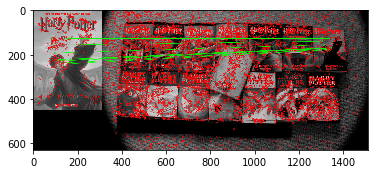

In [87]:
plt.imshow(img3)

In [ ]:
cv2.imwrite('after_matching_test1.png',(img3/np.max(img3)*size_local))
cv2.imshow('Main Image after Matching  ',img3/np.max(img3))
cv2.waitKey(0)
cv2.destroyAllWindows()

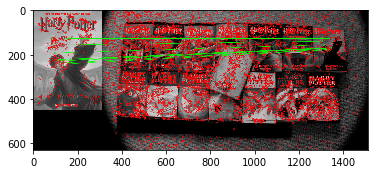

In [88]:
plt.imshow(img3)

# Part b

In [89]:
#StackOverflow 
#Reference : https://stackoverflow.com/questions/53861636/how-can-i-implement-opencvs-perspectivetransform-in-python
def getHomography(sourcePoints, destinationPoints):
    c=[0]*8
    a=[]
    for i in range(8):
        a.append(c)
    a=np.array(a)
    b = [0]*8
    b=np.array(b)
    const=4
    for i in range(const):
        a[i][0] = a[i+4][3] = sourcePoints[i][0]
        a[i][1] = a[i+4][4] = sourcePoints[i][1]
        a[i][2] = a[i+4][5] = 1
        a[i][3] = a[i][4] = a[i][5] = 0
        a[i+4][0] = a[i+4][1] = a[i+4][2] = 0
        a[i][6] = -sourcePoints[i][0]*destinationPoints[i][0]
        a[i][7] = -sourcePoints[i][1]*destinationPoints[i][0]
        a[i+4][6] = -sourcePoints[i][0]*destinationPoints[i][1]
        a[i+4][7] = -sourcePoints[i][1]*destinationPoints[i][1]
        b[i] = destinationPoints[i][0]
        b[i+4] = destinationPoints[i][1]

    result = np.linalg.solve(a, b)
    
    result.resize((9,), refcheck=False)
    result[8] = 1 # Set c22 to 1 as indicated in comment above
    return result.reshape((3,3))

In [90]:
# Match features.
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
clusters = np.array([des1])
bf.add(clusters)
# Train: Does nothing for BruteForceMatcher though.
bf.train()
matches = bf.match(des2)
# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
matches1 = matches[:4]

In [115]:
sourceCorners=[]
destinationCorners=[]
for i in range(len(matches1)):
    sourceCorners.append(np.array(kp1[matches1[i].trainIdx].pt).tolist())
    destinationCorners.append(np.array(kp2[matches1[i].queryIdx].pt).tolist())
    

In [55]:
# # Extract location of good matches
# points1 = np.zeros(len(matches1), 2)
# points2 = np.zeros(len(matches1), 2)
# for i, match in enumerate(matches1):
#     print("hello")
#     points1[i, :] = kp1[match.queryIdx].pt
#     points2[i, :] = kp2[match.trainIdx].pt

In [116]:
sourceCorners

[[167.82859802246094, 221.59242248535156],
 [182.00347900390625, 198.31617736816406],
 [73.91726684570312, 221.02578735351562],
 [97.74259185791016, 192.9557647705078]]

In [121]:
destinationCorners

[[1033.14453125, 169.98336791992188],
 [1039.3863525390625, 159.2791748046875],
 [1081.5283203125, 158.9970703125],
 [1000.0093994140625, 155.92498779296875]]

In [109]:
# #https://github.com/alex011235/CVmosaicPi/blob/master/ransac.py
# def pflat(x):
#     """ Divides each row with the third row """

#     x = x[0:3] / x[2]
#     return x 


# def homogeneous(x):
    

#     return vstack((x,ones((1,x.shape[1]))))


# def homography(x1,x2):
 

#     N = x1.shape[1]
#     M = np.zeros((2*N,9))

#     # DLT
#     for i in range(N):
#         a = x1[0][i]; b = x1[1][i]; c = 1
#         A = x2[0][i]; B = x2[1][i]

#         M[2*i] = [-a, -b, -c, 0,0,0, A*a, A*b, A]
#         M[2*i+1] = [0,0,0, -a, -b, -c, B*a, B*b, B]

#     H = np.linalg.svd(M)[2][8].reshape((3,3))
#     return H / H[2,2]


# def ransac(xA, xB, max_iter = 50, err = 5):


#     inliers_record = 0 
#     xa = xA[0] 
#     ya = xA[1]
#     xb = xB[0]
#     yb = xB[1]
#     H_best = []
#     best_inliers1 = []
#     best_inliers2 = []	

#     for i in range(0, max_iter):
#         xA_rand = zeros((4,2))
#         xB_rand = zeros((4,2))

#         # Choose four random points
#         for j in xrange(0, 4):
#             rand_index = random.randint(xA.shape[1])
#             xA_rand[j,0] = xa[rand_index]; 
#             xA_rand[j,1] = ya[rand_index];
#             xB_rand[j,0] = xb[rand_index]; 
#             xB_rand[j,1] = yb[rand_index];

#         xA_rand = xA_rand.conj().transpose()
#         xB_rand = xB_rand.conj().transpose()	

#         Ht = homography(xB_rand, xA_rand)
#         p1 = vstack((xa,ya,ones((1,xa.shape[0]))))
#         # New model, better?
#         p2 = pflat(linalg.solve(Ht,p1))
#         x = p2[0]
#         y = p2[1]
#         inliers_cand1 = []
#         inliers_cand2 = []	
#         total = 0
#         for k in range(0,len(x)):
#             a = array((x[k],y[k])).conj().transpose()
#             b = array((xb[k],yb[k])).conj().transpose()
#             c = array((xa[k],ya[k])).conj().transpose()
#             # compute error
#             error = linalg.norm(a-b) # nice!	
#             if error < err:
#                 total += 1
#                 inliers_cand1.append(a.conj().transpose())
#                 inliers_cand2.append(c.conj().transpose())

#         # Check if total exceeds the record, then update the best
#         # homography and the inliers.
#         if total > inliers_record:
            
#             inliers_record = total
#             H_best = Ht
#             best_inliers1 = inliers_cand1
#             best_inliers2 = inliers_cand2
#     best_inliers1 = array(best_inliers1)
#     best_inliers2 = array(best_inliers2)
#     H_best = homography(best_inliers1.conj().transpose(),
#     best_inliers2.conj().transpose())

#     return H_best, best_inliers1, best_inliers2

In [122]:
# sourceCorners = np.asarray([[p.pt[0], p.pt[1]] for p in kp1])
# destinationCorners=np.asarray([[p.pt[0], p.pt[1]] for p in kp2])
# Create a transform to change table coordinates in inches to projector coordinates
perspectiveTransform = homography(np.array(sourceCorners), np.array(destinationCorners))

In [123]:
print("Homography Matrix : \n",perspectiveTransform)

Homography Matrix : 
 [[ 3.10642639e-03 -7.86362680e-04 -6.95858538e-03]
 [ 2.20487618e-03  1.90763306e-05 -2.33641909e-06]
 [ 2.38440919e-03 -7.69113152e-03  1.00000000e+00]]


# Part c

In [124]:
def create_bounding_box(test_image, coll, Homography):
  
    collage_image = np.copy(coll)
    height, width = test_image.shape
    points = np.array([[0,0], [0,height-1], [width-1, height-1], [width-1, 0]]).reshape(-1,1,2).astype('float32')
#     print(points)
    point = cv2.perspectiveTransform(points, Homography)
    
    print(point)
    point = np.array((point), np.int64)
    transformed_points = point.reshape(4,2)
    cv2.polylines(collage_image, [transformed_points], True, (255, 0, 0), 5)
    plt.imshow(collage_image)

[[[-6.9585852e-03 -2.3364191e-06]]

 [[ 1.4689447e-01 -3.4935253e-03]]

 [[-3.5379857e-01 -4.0555036e-01]]

 [[ 5.4970783e-01  3.9300960e-01]]]


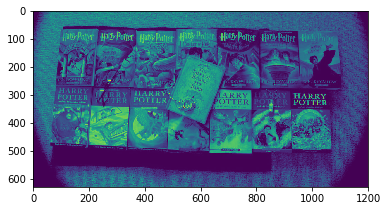

In [125]:
create_bounding_box(img1,img2,perspectiveTransform)